# SCDAA Group Assignment 2024

## Exercise 1

### Exercise 1.1

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import time

In [36]:
class LQRProblem:
    def __init__(self, H, M, C, D, R, sigma, T):
        """
        Initializes the LQR problem with the given matrices and time horizon T.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.S_solution, self.time_solution = None, None  # Will be set after solving Riccati ODE
    
    def riccati_ode(self, t, S_flat, H, M, D_inv, C):
        """
        Defines the Riccati differential equation.
        """
        S = S_flat.reshape(2, 2)
        dSdt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C
        return dSdt.flatten()
    
    def solve_riccati_ode(self, time_grid, atol=1e-10, rtol=1e-10):
        """
        Solves the Riccati ODE on the given time grid using scipy's solve_ivp.
        """
        D_inv = np.linalg.inv(self.D)
        S0_flat = self.R.flatten()
        sol = solve_ivp(
            self.riccati_ode, 
            [self.T, time_grid[0]], 
            S0_flat, 
            t_eval=time_grid[::-1], 
            args=(self.H, self.M, D_inv, self.C), 
            atol=atol, 
            rtol=rtol,
            method='Radau'  # This is a common choice for stiff ODEs
        )
        self.S_solution = sol.y.reshape(2, 2, len(time_grid))[:, :, ::-1]
        self.time_solution = sol.t[::-1]
        return self.S_solution, self.time_solution


    def compute_value_function(self, t_tensor, x_tensor):
        """
        Computes the control problem value v(t, x) for a batch of space x using the solution of S
        and includes the integral term.
        """
       
        batch_size = x_tensor.shape[0]
        
        # Convert all relevant data to PyTorch tensors
        sigma_tensor = torch.tensor(self.sigma, dtype=torch.float32)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float32)
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float32)
        dt = solution_time[1] - solution_time[0]
        
        sigma_squared = sigma_tensor @ sigma_tensor.T
        
        # Ensure t_tensor is 2D for broadcasting
        t_tensor = t_tensor.unsqueeze(1)
        
        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float32), dim=1)
        
        # Initialize v
        v = torch.zeros(batch_size, 1, dtype=torch.float64)
        
        # Pre-compute trace values for each S_tensor slice, to be used in batch operations
        trace_values = torch.einsum('ij,jik->k', sigma_squared, S_tensor)
        
        # Compute the cumulative sum of trace values for integral computation
        cum_integral = torch.cumsum(trace_values, dim=0) * dt
        
        # Adjust cum_integral by subtracting the cumulative sum up to each t, to effectively start from each t
        adjusted_integral = cum_integral[-1] - cum_integral
        
        for i in range(batch_size):
            idx = time_indexes[i]
            
            # Calculate the integral from t to T
            integral_term = adjusted_integral[idx]
            
            # Calculate v for each batch
            S_at_t = S_tensor[:, :, idx]
            v[i] = x_tensor[i].T @ S_at_t @ x_tensor[i] + integral_term

        return v

    def compute_markov_control(self, t_tensor, x_tensor):
        """
        Computes the Markov control function for a batch of x at time t using S(t).
        """
        batch_size = x_tensor.shape[0]

        # Find the index corresponding to the nearest time point in the time grid
        solution_time = torch.tensor(self.time_solution.copy(), dtype=torch.float32)
        S_tensor = torch.tensor(self.S_solution.copy(), dtype=torch.float32)

        # # Ensure t_tensor is 2D for broadcasting
        # t_tensor = t_tensor.unsqueeze(1)
        if t_tensor.shape != (batch_size, 1):
            # Reshape t_tensor to [1, batch_size]
            t_tensor = t_tensor.reshape(batch_size, 1)

        if x_tensor.dtype != torch.float32:
            x_tensor = x_tensor.to(torch.float32)

        # Find indexes where t_tensor < solution_time for all t_tensor in parallel
        # Convert the boolean tensor to float for compatibility with torch.argmax
        time_indexes = torch.argmax((t_tensor <= solution_time).to(dtype=torch.float32), dim=1)

        # Initialize control
        control = torch.zeros(batch_size, 2, dtype=torch.float32)

        D_inv = torch.tensor(np.linalg.inv(self.D), dtype=torch.float32)
        M_T = torch.tensor(self.M.T, dtype=torch.float32)

        # Compute the control using S(t)
        for i in range(batch_size):
            S_t = S_tensor[:, :, time_indexes[i]]
            control[i] = - D_inv @ M_T @ S_t @ x_tensor[i].T  # Make sure the dimensions are correct

        return control

torch.Size([5])


<Figure size 1200x500 with 0 Axes>

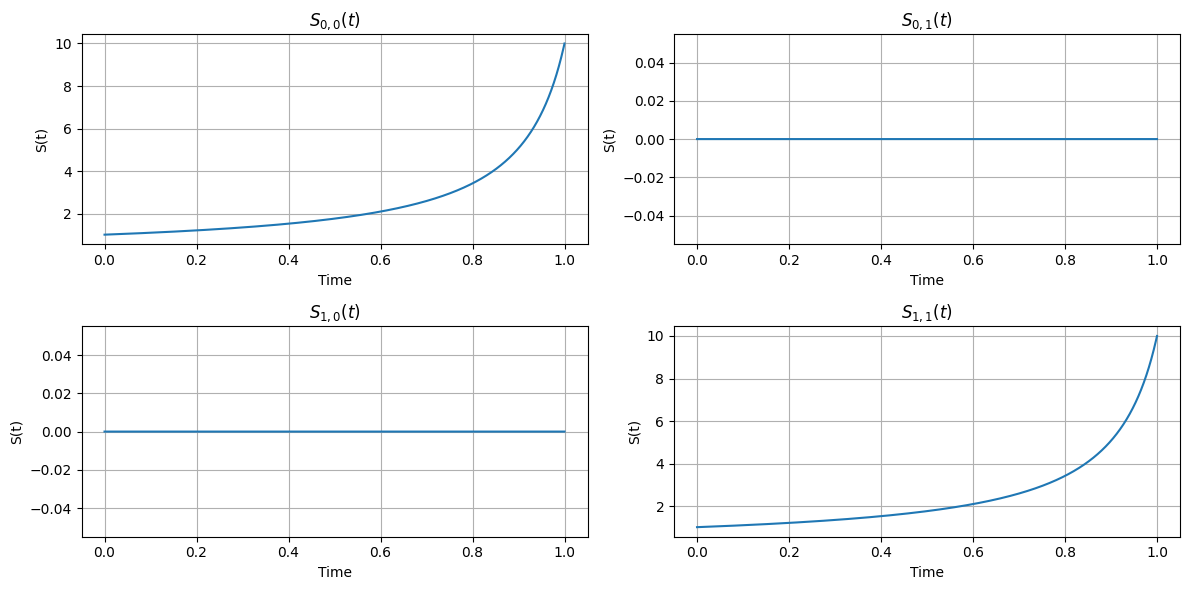

In [38]:
# Example matrices (to be replaced with actual problem data)
H = np.array([[1, 0], [0, 1]]) * 0.1
M = np.array([[1, 0], [0, 1]])
sigma = np.array([[1, 0], [0, 1]]) * 0.001
C = np.array([[0, 0], [0, 0]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[1, 0], [0, 1]]) * 10
T = 1

# Time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)

# Example of using the class (with random time and space inputs for demonstration)
torch.manual_seed(0)  # For reproducibility
random_t = torch.rand(5) * T
print(random_t.shape)
random_x = torch.rand(5, 2) * 6 - 3  # Uniformly sampled from [-3, 3]

# Initialize the LQR problem
lqr_problem = LQRProblem(H, M, C, D, R, sigma, T)
S_solution, time_solution = lqr_problem.solve_riccati_ode(time_grid)

plt.figure(figsize=(12, 6))

# Plot for S[0, 0]
plt.subplot(2, 2, 1)
plt.plot(time_solution, S_solution[0, 0, :], label='$S_{0,0}(t)$')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('$S_{0,0}(t)$')
plt.grid(True)

# Plot for S[0, 1]
plt.subplot(2, 2, 2)
plt.plot(time_solution, S_solution[0, 1, :], label='$S_{0,1}(t)$')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('$S_{0,1}(t)$')
plt.grid(True)

# Plot for S[1, 0] - noting that it's the same as S[0, 1] due to symmetry
plt.subplot(2, 2, 3)
plt.plot(time_solution, S_solution[1, 0, :], label='$S_{1,0}(t)$')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('$S_{1,0}(t)$')
plt.grid(True)

# Plot for S[1, 1]
plt.subplot(2, 2, 4)
plt.plot(time_solution, S_solution[1, 1, :], label='$S_{1,1}(t)$')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('$S_{1,1}(t)$')
plt.grid(True)

# Adjust layout and show all plots
plt.tight_layout()
plt.show()

C:\Users\spyro\AppData\Local\Temp\ipykernel_13324\2442336831.py:87: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  v[i] = x_tensor[i].T @ S_at_t @ x_tensor[i] + integral_term


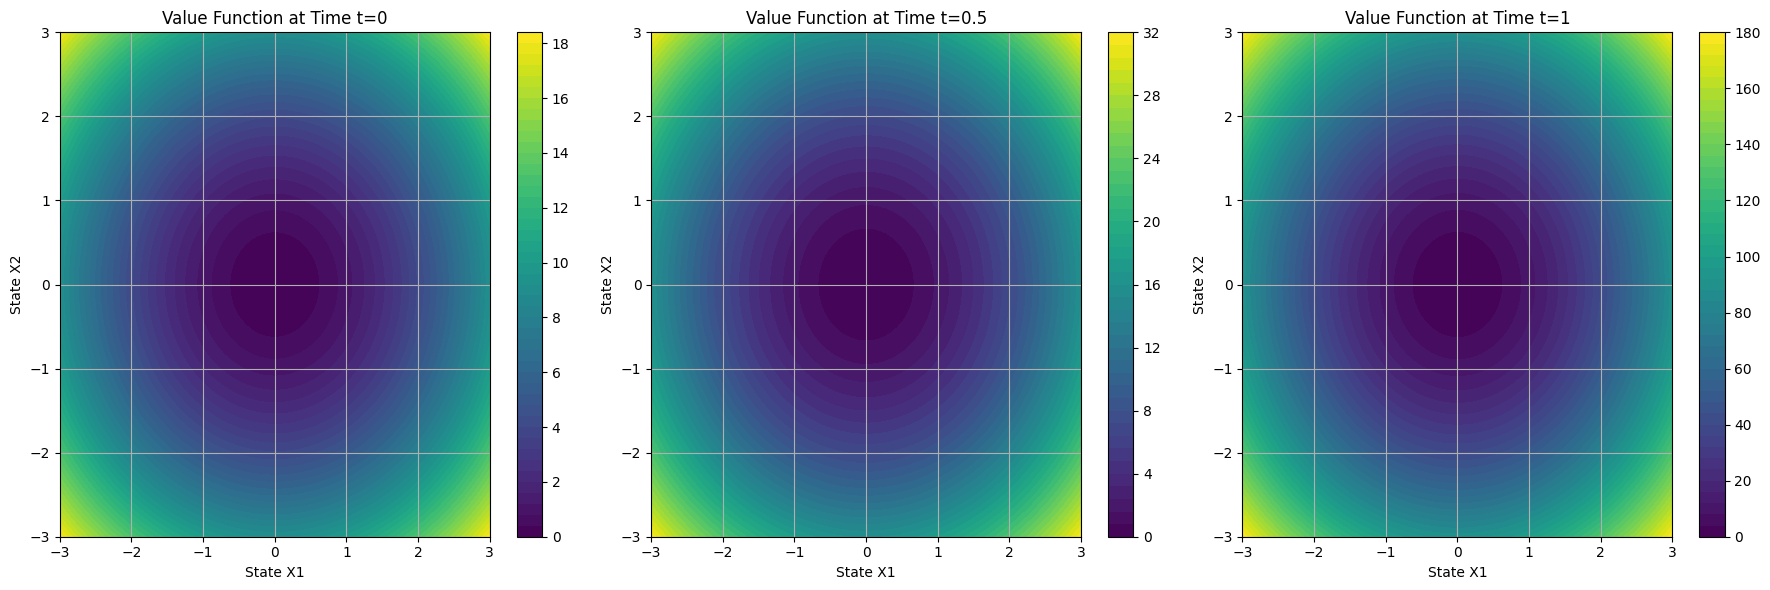

In [39]:
# Solve the Riccati ODE using the given time grid
lqr_problem.solve_riccati_ode(time_grid)

# Time instances of plot
times = [0, T/2, T]

# Generate a grid of state space points to compute the value function
state_space_grid = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(state_space_grid, state_space_grid)

plt.figure(figsize=(18, 6))

for idx, t in enumerate(times, start=1):
    T_tensor = torch.tensor([t], dtype=torch.float32)  # Convert current time to a tensor
    value_function_values = np.zeros_like(X1)
    
    # Compute the value function for each point in the state space grid at the current time
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = torch.tensor([[X1[i, j], X2[i, j]]], dtype=torch.float32)  # Shape: [1, 2]
            val = lqr_problem.compute_value_function(T_tensor, x).item()  # Use T_tensor
            value_function_values[i, j] = val
    
    # Plotting the value function for the current time
    plt.subplot(1, 3, idx)
    cp = plt.contourf(X1, X2, value_function_values, cmap='viridis', levels=50)
    plt.colorbar(cp)
    plt.xlabel('State X1')
    plt.ylabel('State X2')
    plt.title(f'Value Function at Time t={t}')
    plt.grid(True)

plt.tight_layout()
plt.show()

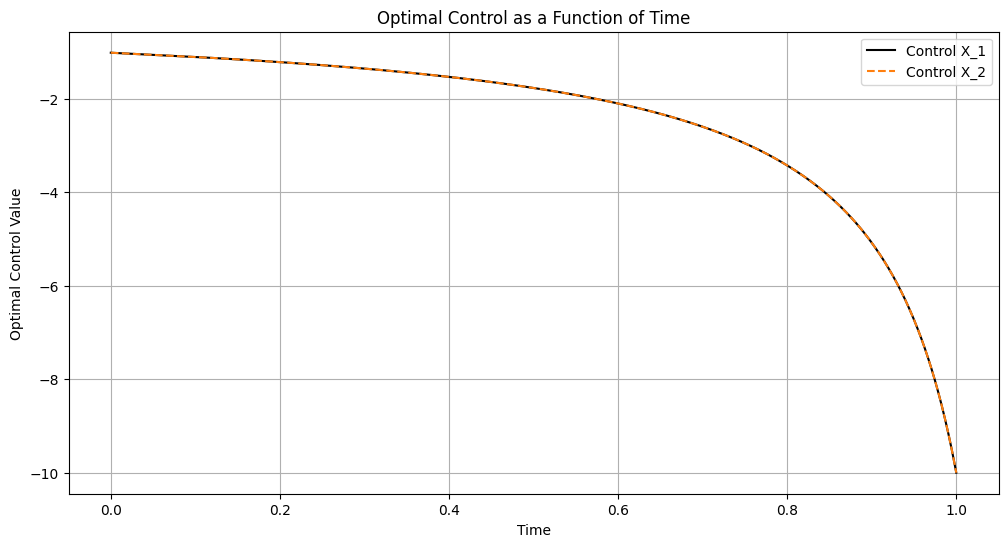

In [44]:
num_points = 1000  # Number of points in time to evaluate
initial_state = torch.tensor([[1, 1]], dtype=torch.float32)  # Initial state space point

# Create an array of time points
time_points = torch.linspace(0, T, num_points)

# Preallocate array for optimal control values
optimal_controls = np.zeros((num_points, 2))  # Assuming control is 2-dimensional

# Compute the optimal control for each time point
for i, t in enumerate(time_points):
    current_time = t.unsqueeze(0)  # Add batch dimension
    control = lqr_problem.compute_markov_control(current_time, initial_state)
    optimal_controls[i] = control.detach().numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Plot each component of the control
plt.plot(time_points, optimal_controls[:, 0], 'k', label='Control X_1')
plt.plot(time_points, optimal_controls[:, 1], 'C1--', label='Control X_2')

plt.xlabel('Time')
plt.ylabel('Optimal Control Value')
plt.title('Optimal Control as a Function of Time')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 1.2

In [7]:
def simulate_dynamics(lqr_problem, t0, x0, N_steps, num_samples):
    dt = (lqr_problem.T - t0) / N_steps
    costs_all_paths = []
    
    
    # Convert system matrices to tensors, including D_inv_MT
    H_tensor = torch.tensor(lqr_problem.H, dtype=torch.float32)
    M_tensor = torch.tensor(lqr_problem.M, dtype=torch.float32)
    sigma_tensor = torch.tensor(lqr_problem.sigma, dtype=torch.float32)
    C_tensor = torch.tensor(lqr_problem.C, dtype=torch.float32)
    D_tensor = torch.tensor(lqr_problem.D, dtype=torch.float32)

    for _ in range(num_samples): 
        cost_path = 0.0
        
        x_T = x0.clone().detach().view(1, 2)
        for step in range(N_steps):
            t = t0 + step * dt
            step_opt_control_T = lqr_problem.compute_markov_control(t, x_T)
            step_opt_control = step_opt_control_T.T
            x = x_T.T
            drift = H_tensor @ x + M_tensor @ step_opt_control
            dW = (torch.randn(2, dtype=torch.float32) * torch.sqrt(dt)).unsqueeze(1)
            x += drift * dt + sigma_tensor @ dW
            x_T = x.T
            cost_path += (x.T @ C_tensor @ x + step_opt_control.T @ D_tensor @ step_opt_control) * dt

        cost_path += x.T @ torch.tensor(lqr_problem.R, dtype=torch.float32) @ x

        costs_all_paths.append(cost_path.item())

    MC_value = np.average(costs_all_paths)

    return MC_value

Iteration: 0 | Time taken: 51.83137488365173 seconds
Iteration: 1 | Time taken: 253.04645490646362 seconds
Iteration: 2 | Time taken: 505.443555355072 seconds
Iteration: 3 | Time taken: 2701.0024762153625 seconds
Iteration: 4 | Time taken: 5697.279808998108 seconds
Iteration: 5 | Time taken: 24087.103548765182 seconds


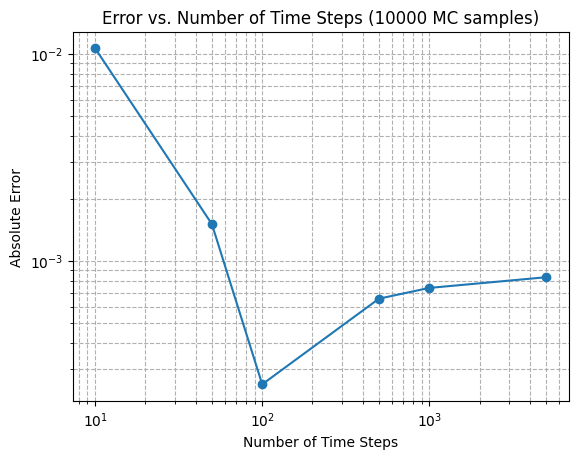

In [10]:
# Initial conditions
t0 = torch.tensor([0.7], dtype=torch.float32)
x0 = torch.tensor([1.0, 1.0])  

# Number of time steps and Monte Carlo samples for the simulation
N_steps_list = [10, 50, 100, 500, 1000, 5000]
num_samples = 10000

# Generate a time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)  # Fine time grid for better accuracy
lqr_problem.solve_riccati_ode(time_grid)

# Compute the theoretical value at the initial state x0
analytical_opt_value = lqr_problem.compute_value_function(t0, x0.unsqueeze(0)).item()

# Run the simulation and compute errors for different numbers of time steps
errors = []
iteration = 0
for N_steps in N_steps_list:
    start_time = time.time()
    MC_opt_value = simulate_dynamics(lqr_problem, t0, x0, N_steps, num_samples)
    error = abs(MC_opt_value - analytical_opt_value)
    errors.append(error)
    end_time = time.time()
    print('Iteration:', iteration, '| Time taken:', end_time - start_time, 'seconds')
    iteration += 1

# Plot the error vs. number of time steps
plt.loglog(N_steps_list, errors, marker='o')
plt.xlabel('Number of Time Steps')
plt.ylabel('Absolute Error')
plt.title(f'Error vs. Number of Time Steps ({num_samples} MC samples)')
plt.grid(True, which="both", ls="--")
plt.show()


Iteration: 0 | Time taken: 21.63062310218811 seconds
Iteration: 1 | Time taken: 106.57465648651123 seconds
Iteration: 2 | Time taken: 217.2447645664215 seconds
Iteration: 3 | Time taken: 1074.5439715385437 seconds
Iteration: 4 | Time taken: 2175.917815208435 seconds
Iteration: 5 | Time taken: 10798.483567476273 seconds
Iteration: 6 | Time taken: 21636.88931441307 seconds


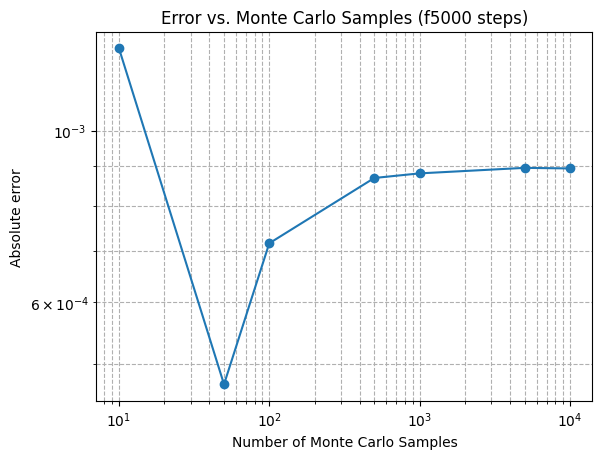

In [10]:
# Step 1: Fix a large number of time steps
N_steps_fixed = 5000

# Step 2: No changes needed here
# Initial conditions
t0 = torch.tensor([0.7], dtype=torch.float32)
x0 = torch.tensor([1.0, 1.0]) 
# Generate a time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 10000)  # Fine time grid for better accuracy
lqr_problem.solve_riccati_ode(time_grid)

# Compute the theoretical value at the initial state x0
analytical_opt_value = lqr_problem.compute_value_function(t0, x0.unsqueeze(0)).item()

# Step 3: Vary the number of Monte Carlo samples and compute errors
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000]
errors = []

iteration = 0
for num_samples in num_samples_list:
    start_time = time.time()  # Start timing
    MC_opt_value = simulate_dynamics(lqr_problem, t0, x0, N_steps_fixed, num_samples)
    error = abs(MC_opt_value - analytical_opt_value)
    errors.append(error)
    end_time = time.time()  # End timing
    print('Iteration:', iteration, '| Time taken:', end_time - start_time, 'seconds')
    iteration += 1

# Step 4: Plot the error on a log-log plot
plt.loglog(num_samples_list, errors, marker='o', linestyle='-')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('Absolute error')
plt.title(f'Error vs. Monte Carlo Samples ({N_steps_fixed} steps)')
plt.grid(True, which="both", ls="--")
plt.show()
